# CAS Machine Intelligence - Machine Learning Projekt
Autor: Simon Würsten

Datum: April 2020

Datenset: [House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview/description) (Kaggle Competition).

Ich habe Codefragmente von den[ Python-Tutoroal-Kernels von Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview/tutorials) sowie von [Scikit-Learn ML-Tutorials](https://scikit-learn.org/stable/index.html) benutzt. Das Ziel der Kaggle-Competition ist eine Prediction des Verkaufspreises (*SalePrice*) auf dem vorgegebenen Testset mit möglichst tiefem RMSE zu erstellen. Das Feature Engineering könnte in meinem Projekt viel umfassender ausfallen, jedoch soll primär die Performance/Qualität von verschiedenen ML-Modelle im Hinblick auf einen tiefen RMSE verglichen werden.

## Load Packages

In [0]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from sklearn import linear_model, preprocessing, svm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import f_regression, SelectPercentile, VarianceThreshold

## Define Functions

In [0]:
def load_data():
    """
    load training and test data.    
    """
    df_train = pd.read_csv("train.csv")
    df_train = df_train.drop(columns=['Id']) # no need
    
    df_test = pd.read_csv("test.csv")
    df_test = df_test.drop(columns=['Id']) # no need
    df_test['SalePrice'] = pd.read_csv("sample_submission.csv")['SalePrice']
    return df_train, df_test


def missing_data(df, cols):
    """
    get total and percentage of missing data.
    """
    missing_total = df[cols].isnull().sum().sort_values(ascending=True)
    missing_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=True)
    missing_data = pd.concat([missing_total, missing_percent], axis=1, keys=['missing_total', 'missing_percent'])
    missing_data = missing_data[missing_data.missing_total > 0]
    return missing_data


def get_col_type(df):
    """
    separate numeric and categorical variables.
    """
    col_quant = [f for f in df.columns if df.dtypes[f] != 'object']
    col_quant.remove('SalePrice') # target variable not needed in this selection
    col_qual = [f for f in df.columns if df.dtypes[f] == 'object']
    return col_quant, col_qual

    
def data_preprocessing(df):
    """
    really basic and naive preprocess data.
    """
    col_quant, col_qual = get_col_type(df)
    
    #---- missing data ----#
    #---- Quantitative
    print("missing numeric var:\n", missing_data(df, col_quant))    
    # replace NA with median
    df[col_quant] = df[col_quant].fillna(df[col_quant].median())
    
    #---- Qualitative
    print("missing categorical var:\n", missing_data(df, col_qual))    
    # replace NA with missing
    for c in col_qual:
        if df[c].isnull().any():
            df[c] = df[c].fillna('missing')
            
    #---- tranformations ----#
    # log transform sale price
    df["SalePrice"] = np.log1p(df["SalePrice"])        
    # log transform skewed features    
    skewed_feats = df[col_quant].apply(lambda x: skew(x)) # compute skewness per feature
    skewed_feats_sel = skewed_feats[skewed_feats > 0.75] # transform only features with skewness > 0.75
    skewed_feats_sel = skewed_feats_sel.append(skewed_feats[skewed_feats < -0.75]) # add and transform only features with skewness < -0.75
    skewed_feats_sel = skewed_feats_sel.index  
    df[skewed_feats_sel] = np.log1p(df[skewed_feats_sel])           
    return df


def equal_category(df_train, df_test):
    """
    add missing categories to test set based on categories from traininng data.
    Otherwise dummy creation leads to different amount of features due to not every category present in test-set.
    """
    col_quant, col_qual = get_col_type(df_train)
    
    for col in col_qual:
        # get categories from train set
        df_train[col] = df_train[col].astype('category')        
        cats = df_train[col].cat.categories
        # create dummy variables for test set
        dummies = pd.get_dummies(df_test[col], drop_first=True)
        dummies = dummies.reindex(columns=cats[1:], fill_value=0)        
        df_test = df_test.drop(columns=col)
        df_test[dummies.columns] = dummies
        # create dummy variables for train set
        dummies = pd.get_dummies(df_train[col], drop_first = True)
        df_train = df_train.drop(columns=col)
        df_train[dummies.columns] = dummies    
    return df_train, df_test


def plot_sale_price(df_train, df_test, plt_title):
    """
    plot sale price from train and test in same plot.
    """
    tr_sale_price = df_train.SalePrice
    te_sale_price = df_test.SalePrice
    sns.distplot(tr_sale_price, color="skyblue", label="Training")
    sns.distplot(te_sale_price, color="red", label="Test")
    plt.legend()
    plt.title(plt_title)
 
    
def plot_quant_var(df):
    """
    plot numeric variables in a grid.
    """
    col_quant, col_qual = get_col_type(df)

    f = pd.melt(df, value_vars=col_quant)
    g = sns.FacetGrid(f, col="variable",  col_wrap=8, sharex=False, sharey=False)
    g = g.map(sns.distplot, "value", kde = False)


def model_evaluation(test_y, train_y, pred_test_y, pred_train_y, model, df_summary, fit = None):
    """    
    print and plot some diagnostics for linear model:
        - coefficients (not applicable for SVR)
        - RMSE
        - R2
        - Residuals (not applicable for SVR)
        - Prediction vs. Truth
    """
    if model != 'SVR':
        # coefficients
        print('Coefficients: \n', fit.coef_)
    
    print('############# TEST SET #############')
    # mean squared error
    print('Mean squared error: %.2f' % mean_squared_error(test_y, pred_test_y))
    # coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.2f' % r2_score(test_y, pred_test_y))
    
    print('############# TRAINING SET #############')
    # mean squared error
    print('Mean squared error: %.2f' % mean_squared_error(train_y, pred_train_y))
    # coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.2f' % r2_score(train_y, pred_train_y))       
    
    if model != 'SVR':
        # Plot residuals
        plt.scatter(pred_train_y, pred_train_y - train_y, c = "blue", label = "Training data")
        plt.scatter(pred_test_y, pred_test_y - test_y, c = "lightgreen", label = "Test data")
        plt.title("Residuals")
        plt.xlabel("Predicted values")
        plt.ylabel("Residuals")
        plt.legend(loc = "upper left")
        plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
        plt.show()    
    
    # Plot predictions
    plt.scatter(np.exp(pred_train_y)-1, np.exp(train_y)-1, c = "blue", label = "Training data")
    plt.scatter(np.exp(pred_test_y)-1, np.exp(test_y)-1, c = "lightgreen", label = "Test data")
    plt.title("Y True vs. Y Pred")
    plt.xlabel("Predicted values")
    plt.ylabel("Real values")
    plt.legend(loc = "upper left")
    plt.show()
    
    df_summary = df_summary.append({'Model':model, 
                                      'RMSE_train':mean_squared_error(train_y, pred_train_y), 
                                      'RMSE_test':mean_squared_error(test_y, pred_test_y),
                                      'R2_train':r2_score(train_y, pred_train_y),
                                      'R2_test':r2_score(test_y, pred_test_y)}, ignore_index=True)
    return df_summary


def scale_input(df):
    """
    scale model inputs.
    """
    col_quant, col_qual = get_col_type(df)
    df[col_quant] = preprocessing.scale(df[col_quant])
    return df


def get_input_dataset(df_train, df_test):
    """
    split datasets in predictors and target.
    """
    train_y = df_train['SalePrice']
    train_x = df_train.drop(columns=['SalePrice'])
    
    test_y = df_test['SalePrice']
    test_x = df_test.drop(columns=['SalePrice'])
    return train_x, train_y, test_x, test_y


## Make Datasets ML Ready

In [11]:
#---- load data ----#
df_train, df_test = load_data()
print(df_train)

      MSSubClass MSZoning  LotFrontage  ...  SaleType SaleCondition SalePrice
0             60       RL         65.0  ...        WD        Normal    208500
1             20       RL         80.0  ...        WD        Normal    181500
2             60       RL         68.0  ...        WD        Normal    223500
3             70       RL         60.0  ...        WD       Abnorml    140000
4             60       RL         84.0  ...        WD        Normal    250000
...          ...      ...          ...  ...       ...           ...       ...
1455          60       RL         62.0  ...        WD        Normal    175000
1456          20       RL         85.0  ...        WD        Normal    210000
1457          70       RL         66.0  ...        WD        Normal    266500
1458          20       RL         68.0  ...        WD        Normal    142125
1459          20       RL         75.0  ...        WD        Normal    147500

[1460 rows x 80 columns]


### Visual Inspection with Histograms

#### Sale Price (Target)
Das Testdatenset hat einen viel höheren Peak als das Trainingsset und ist steiler. Die Trainingsdaten sind rechtsschief mit einem langen Schwanz (Outliers?). Eine Log-Transformation des Verkaufspreises bietet sich an.

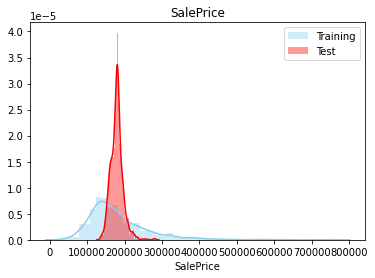

In [12]:
#---- plot sale price (target) ----#
plot_sale_price(df_train, df_test, 'SalePrice')

In [13]:
print("skewness train data:", skew(df_train['SalePrice']))
print("skewness test data:", skew(df_test['SalePrice']))
print("kurtosis train data:", kurtosis(df_train['SalePrice']))
print("kurtosis test data:", kurtosis(df_test['SalePrice']))

skewness train data: 1.880940746034036
skewness test data: 0.9284042347347871
kurtosis train data: 6.509812011089439
kurtosis test data: 3.777619932266636


#### numerische Variablen
Die numerischen Variablen weisen ganz unterschiedliche Verteilungen auf. Einige sind in Wahrheit vermutlich auch kategorielle und ordinale Variablen (bspw. *OverallQual*, *YearBuilt*). Die numerischen Variablen werden abhängig ihrer Skewness im nächsten Schritt pragmatisch Log-Transformiert.

Auf eine Darstellung der kategoriellen Variablen habe ich verzichtet.

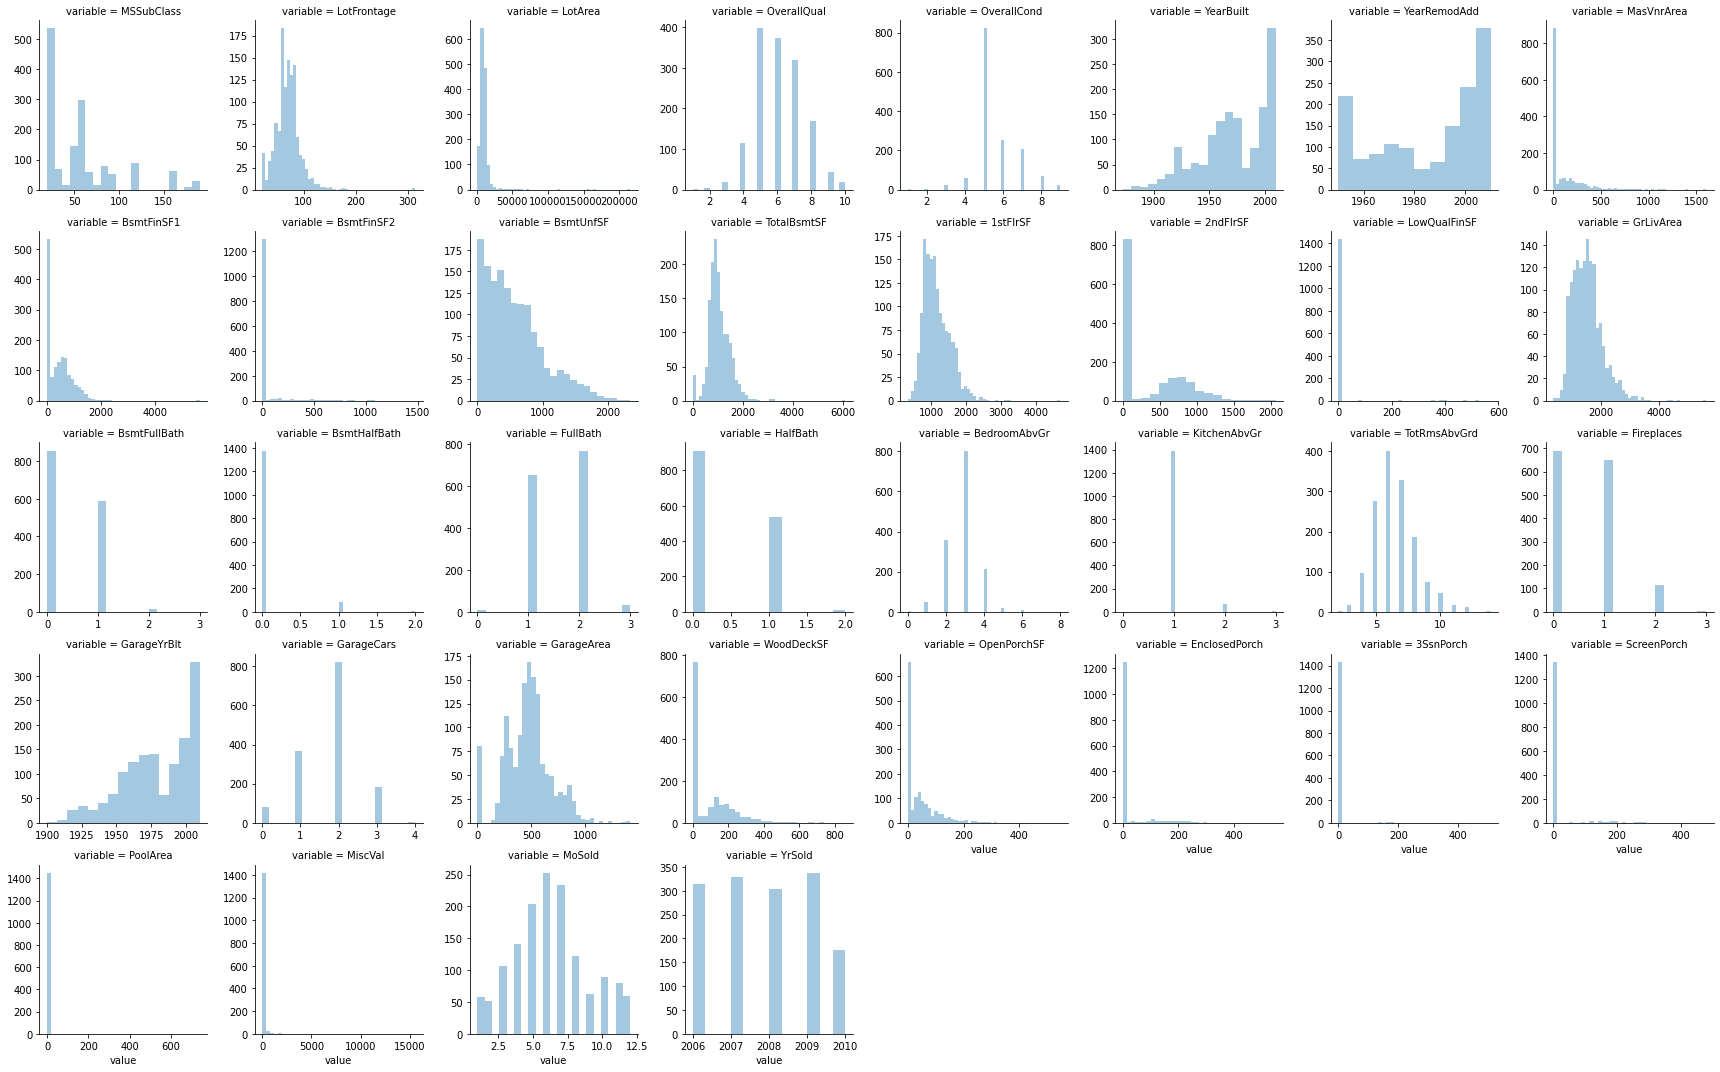

In [8]:
#---- plot numeric vars ----#
plot_quant_var(df_train)

### Preprocessing and Visual Inspection again

In [14]:
#---- preprocess data ----#
print('############# TEST SET #############')
df_train = data_preprocessing(df_train)
print('############# TRAINING SET #############')
df_test = data_preprocessing(df_test)
# make categories equal
df_train, df_test = equal_category(df_train, df_test)
print(df_train)

############# TEST SET #############
missing numeric var:
              missing_total  missing_percent
MasVnrArea             8.0         0.005479
GarageYrBlt           81.0         0.055479
LotFrontage          259.0         0.177397
missing categorical var:
               missing_total  missing_percent
Electrical              1.0         0.000685
MasVnrType              8.0         0.005479
BsmtCond               37.0         0.025342
BsmtQual               37.0         0.025342
BsmtFinType1           37.0         0.025342
BsmtExposure           38.0         0.026027
BsmtFinType2           38.0         0.026027
GarageType             81.0         0.055479
GarageFinish           81.0         0.055479
GarageQual             81.0         0.055479
GarageCond             81.0         0.055479
FireplaceQu           690.0         0.472603
Fence                1179.0         0.807534
Alley                1369.0         0.937671
MiscFeature          1406.0         0.963014
PoolQC             

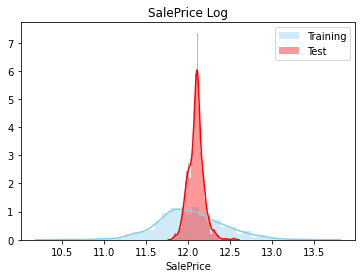

In [15]:
#---- plot target after transformation ----#
plot_sale_price(df_train, df_test, 'SalePrice Log')

## Create Models
Die Competition ist ein zu lösendes Regressions-Problem. Dafür verwende ich folgende Methoden:
- Multiples Regressionsmodell
- Multiples Regressionsmodell mit Feature Selection
- Ridge Regression mit Grid Search und Cross Validation des *Alpha*-Parameters
- SVM bzw. SVR mit Grid Search und Cross Validation der Tuning Parameter *C*, *Gamma* und *Kernel*

Als einfachstes Modell verwende ich ein multiples Regressionsmodell um zu schauen, ob das was taugt (vermutlich nicht) und wie es performt.

Im nächsten Modell, das immer noch ein lineares Modell ist, werden mit `VarianceThreshold` Prädiktoren vom Datenset entfernt, welche eine zu niedrige Varianz aufweisen. Zudem wird die lineare Abhängigkeit mit `SelectPercentile(f_regression)` der einzelnen Prädiktoren mit der Zielvariable berechnet und nur die einflussreichsten Variablen behalten. Dies soll ein krasser Gegensatz zum simplen Linearen Modell darstellen um zu schauen, ob sich dadurch die Performance verbessert.

Im dritten Modell kommt Ridge Regression zur Anwendung, wobei der passende Alpha-Parameter mit einem Grid Search ermittelt wird. Damit sollte Kollinearität abgefedert werden, indem zu grosse Koeffizienten mit einem Term bestraft werden. Zudem werden so faktisch auch die Dimensionen reduziert. Dieses Modell soll aufzeigen, ob eine Prognose ohne "manueller" Feature Selection wie im linearen Fall auch die Performance verbessert.

Als komplexesten Ansatz wird letztlich Support Vector Regression verwendet. Ebenfalls mit Grid Search werden die optimalen Parameter in Bezug auf einen kleinen RMSE ermittelt. Dieses Modell sollte auch mit Nicht-Linearität umgehen können. Es wäre interessant zu sehen, wie im Vergleich dazu bspw. Kernel Ridge Regression oder Gaussian Process Regression performt. Die Wahl fiel u.a. auf SVM bzw. SVR, weil ich schon oft davon gehört habe und diese Methode deshalb schon immer mal ausprobieren wollte. Natürlich könnte auch GAM oder logistische Regression zur Anwendung kommen, insbesondere, weil die ebenfalls mit Nicht-Linearität umgehen können. Diese Methoden wurden jedoch bereits im CAS Statistical Modelling behandelt und ich wollte hier u.a. auch neue Modelle bzw. eben Machine Learning ausprobieren.



In [0]:
#---- create dataframe for performance measures for each model ----#
df_ml_summary = pd.DataFrame(columns = ['Model', 'RMSE_train', 'RMSE_test', 'R2_train', 'R2_test'])

#### Linear Model All Features

Coefficients: 
 [-2.30786961e-02  3.08517244e-02  7.66666460e-02  4.86687257e-02
  4.37766921e-02  2.18748291e-03  6.65741757e-04  6.13837779e-03
  8.84651218e-03  4.46617222e-03 -3.51116451e-03  2.36289025e-02
  3.74623877e-02 -2.52638421e-03 -9.33359283e-03  4.27102155e-01
  3.32561742e-02  1.55886842e-02  3.04320446e-02  2.31244255e-02
 -1.68249473e-02 -1.45557072e-01  8.52070572e-03  2.38082379e-02
  1.92027205e-04  2.15288034e-02  7.47492540e-05  3.78913520e-03
  1.80790291e-03  3.29744732e-03  5.22235395e-03  9.97878802e-03
  3.16978667e-02 -1.00232279e-02 -1.26238557e-03 -2.00938803e-03
  4.28018925e-01  3.96193989e-01  4.06869558e-01  3.79621886e-01
  4.83593344e-02 -9.00881500e-02  1.95543274e-02  1.96306740e-02
  7.96071816e-03  4.35641629e-02  3.77893534e-03  2.33180685e-02
 -2.16666641e-01  2.93126354e-02 -3.31536885e-02 -8.69972917e-02
 -4.52004415e-03 -2.86619995e-02 -2.75916822e-01 -2.46181012e-02
  3.79119341e-03  2.46632381e-02  8.21153188e-03 -2.44764298e-02
  9.86367

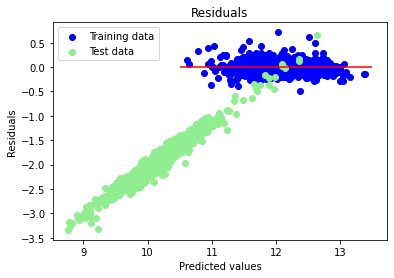

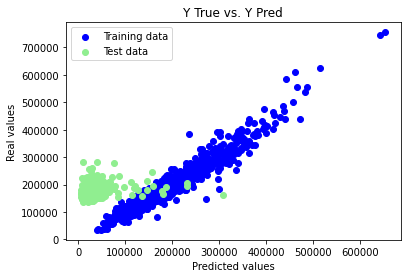

In [17]:
train_x, train_y, test_x, test_y = get_input_dataset(df_train, df_test)

# fit model
regr = linear_model.LinearRegression()
regr.fit(train_x, train_y)

# make predictions
pred_train_y = regr.predict(train_x)
pred_test_y = regr.predict(test_x)

df_ml_summary = model_evaluation(test_y, train_y, pred_test_y, pred_train_y, 'Linear All Features', df_ml_summary, regr)

#### Linear Model with Feature Selection

verbleibende Spalten: ['OverallQual', 'YearBuilt', 'FullBath', 'GarageCars', 'GarageArea']
Coefficients: 
 [0.15588684 0.00099352 0.10730682 0.05929127 0.00028706]
############# TEST SET #############
Mean squared error: 0.13
Coefficient of determination: -14.74
############# TRAINING SET #############
Mean squared error: 0.04
Coefficient of determination: 0.75


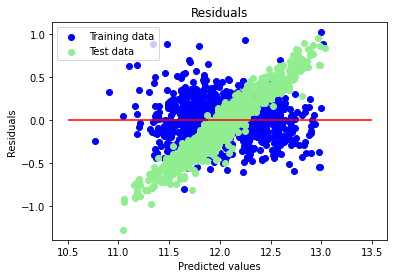

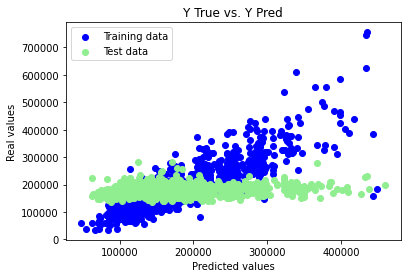

In [18]:
train_x, train_y, test_x, test_y = get_input_dataset(df_train, df_test)

# remove features with low variance
selector = VarianceThreshold(threshold=(.8 * (1 - .8)))
selector.fit_transform(train_x)
selector_cols_id = selector.get_support(indices=True)
train_x = train_x.iloc[:,selector_cols_id]
test_x = test_x.iloc[:,selector_cols_id]

# remove features based on univariate linear regression tests
selector = SelectPercentile(f_regression)
selector.fit(train_x, train_y)
selector_cols_id = selector.get_support(indices=True)
train_x = train_x.iloc[:,selector_cols_id]
test_x = test_x.iloc[:,selector_cols_id]

print("verbleibende Spalten:", list(train_x.columns) )

# fit model
regr = linear_model.LinearRegression()
regr.fit(train_x, train_y)

# make predictions
pred_train_y = regr.predict(train_x)
pred_test_y = regr.predict(test_x)

df_ml_summary = model_evaluation(test_y, train_y, pred_test_y, pred_train_y, 'Linear Feature Selection', df_ml_summary, regr)

#### Ridge Regression

bestes Alpha: 9
Coefficients: 
 [-2.10344885e-02  9.04085597e-03  7.45962827e-02  6.32259329e-02
  4.45727601e-02  1.89033434e-03  7.95999464e-04  1.86950263e-03
  9.31504225e-03  1.26940840e-03 -3.63111833e-03  2.22243993e-02
  1.26808779e-01  5.66503804e-03 -5.88684029e-04  2.27845692e-01
  3.21860287e-02  7.17677025e-03  4.29787873e-02  3.21721816e-02
 -5.23954555e-03 -4.89182133e-02  1.23103542e-02  2.98765250e-02
  6.47173191e-05  4.85094634e-02  6.55948341e-06  3.96898528e-03
  1.88313662e-03  3.80752191e-03  5.94895331e-03  1.00757748e-02
 -4.54371029e-03 -3.82812766e-03 -9.46334178e-04 -4.12409103e-03
  7.51755408e-02  4.68924823e-02  7.62366897e-02  4.88461299e-02
  2.78934502e-02  2.53752669e-03  1.46788677e-02 -5.85951710e-02
  4.40923850e-03  4.64510978e-02  2.26274690e-02  3.28272277e-02
 -1.79583333e-02  3.17959325e-02 -3.32886070e-02 -2.48156426e-02
 -4.71533628e-03 -4.34958681e-03 -2.49198736e-02 -4.91993507e-03
  5.02363210e-03  2.59990253e-02  3.24612031e-02 -1.481254

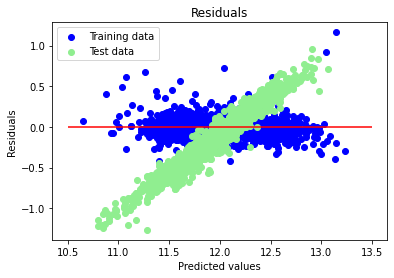

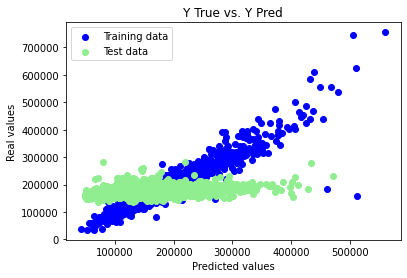

In [19]:
train_x, train_y, test_x, test_y = get_input_dataset(df_train, df_test)

# set alphas
alphas = alphas = np.arange(1, 50)

# grid search and fit
ridge = linear_model.RidgeCV(alphas = alphas, scoring='neg_root_mean_squared_error', cv=5)
ridge.fit(train_x, train_y)

print("bestes Alpha:", ridge.alpha_)

# make predictions
pred_train_y = ridge.predict(train_x)
pred_test_y = ridge.predict(test_x)

df_ml_summary = model_evaluation(test_y, train_y, pred_test_y, pred_train_y, 'Ridge Regression', df_ml_summary, ridge)

#### Support Vector Regression

SVR beste Parameter: {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
############# TEST SET #############
Mean squared error: 0.14
Coefficient of determination: -16.26
############# TRAINING SET #############
Mean squared error: 0.01
Coefficient of determination: 0.92


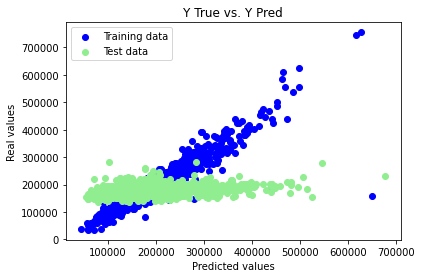

In [20]:
# scale datasets
df_train_s = scale_input(df_train)
df_test_s = scale_input(df_test)

train_x, train_y, test_x, test_y = get_input_dataset(df_train_s, df_test_s)

# set tuning parameters
tuned_parameters = [{'kernel': ['rbf', 'poly'],
                    'gamma': [0.001, 0.0001],
                    'C': [0.1, 0.3, 0.5, 0.8, 1, 2, 4, 10, 100]}]

# set scores
scores = ['neg_root_mean_squared_error', 'r2']

# grid search and fit
svr = GridSearchCV(svm.SVR(cache_size=2000), param_grid=tuned_parameters, scoring=scores, cv=5, refit='neg_root_mean_squared_error', return_train_score=True)
svr.fit(train_x, train_y)

print("SVR beste Parameter:", svr.best_params_)

# make predictions
pred_train_y = svr.predict(train_x)
pred_test_y = svr.predict(test_x)

df_ml_summary = model_evaluation(test_y, train_y, pred_test_y, pred_train_y, 'SVR', df_ml_summary)   

### Summary

In [25]:
print("Summary oof models ordered by 'Test-RMSE'")
df_ml_summary.sort_values(by=['RMSE_test'])

Summary oof models ordered by 'Test-RMSE'


,Model,RMSE_train,RMSE_test,R2_train,R2_test
1,Linear Feature Selection,0.040079,0.127570,0.748646,-14.741822
3,SVR,0.012690,0.139882,0.920413,-16.261073
2,Ridge Regression,0.013088,0.168252,0.917916,-19.761868
0,Linear All Features,0.010226,4.079504,0.935865,-502.401849


In [26]:
print("Summary oof models ordered by 'Test-R2'")
df_ml_summary.sort_values(by=['R2_test'], ascending=False)

Summary oof models ordered by 'Test-R2'


,Model,RMSE_train,RMSE_test,R2_train,R2_test
1,Linear Feature Selection,0.040079,0.127570,0.748646,-14.741822
3,SVR,0.012690,0.139882,0.920413,-16.261073
2,Ridge Regression,0.013088,0.168252,0.917916,-19.761868
0,Linear All Features,0.010226,4.079504,0.935865,-502.401849


Grundsätzlich scheinen alle Modelle ziemlich zu overfitten und sind gemäss Test-R2-Score, der zwischen 0 und 1 liegen sollte, in meinem Fall aber immer negativ war, nicht zu gebrauchen. Mit dem erhaltenen RMSE bewege ich mich im tiefen unteren Bereich des Kaggle-Leaderboards dieser Competition. Die Güte könnte mit intelligenterer Transformation, ausgefeilterem Feature Engineering (neue Variablen erstellen) und Inferenz bestimmt verbessert werden. Mir ist ausserdem nicht ganz klar, inwiefern die ungleiche Verteilung der Zielvariablen zwischen Training- und Testset die Ergebnisse beeinflussen. 

Es ist nicht erstaunlich, dass das simple lineare Modell mit allen Features die weitaus schlechteste Voraussagen liefert mit einem RMSE von ca. -500. Die Residuen des Trainingsset sind zwar normalverteilt, aber diejenigen des Testset weisen einen systematischen Fehler auf und liegen irgendwo daneben. Dies trifft  ebenfalls für die Predictions zu (vgl. entsprechender Plot), die massiv zu tief vorausgesagt werden. Es gibt einige korrelierende Variablen, also ist Kollinearität bestimmt ein Problem für dieses Modell. Im Gegensatz dazu ist es auch erstaunlich, dass das lineare Modell mit nur 5 verbleibenden Features von über 180 den besten RMSE- und R2-Wert aller Modelle liefert. Ridge Regression und SVR performen ähnlich gut, trotz mit höherem Train-R2-Wert. Das zeigt auf, dass die komplexeren Modelle trotz stärkerem Overfitting mit neuen Daten ähnlich gut umgehen können.

Abgesehen vom ersten linearen Modell müsste die Richtung der Predictions grundsätzlich stimmen, da die Testedaten im Target einen sehr hohen Peak aufweisen und steiler sind als die Trainingsdaten.

Ich finds interessant zu sehen, dass ein an sich nicht so komplexes Modell besser performt als ein viel komplexeres. Dies bestätigt mich in meiner Ansicht, dass ein durchdachtes Feature Engineering, zumindest für solche Probleme, sinnvoller sein kann als ein komplexes Modell zu verwenden in der Hoffnung, das komme mit den Daten schon zurecht (was ich immer wieder antreffe in meinem Umfeld).